In [1]:
import sys
import os
import random

import torch

import config
import pprint
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from shutil import copyfile
from torch.utils.data import random_split

In [2]:
sys.path.append('models/detection')
sys.path.append('models/detection/FasterRCNN')
sys.path.append('utils')

from models.detection.models import *
from utils.evaluate_utils import AdvDetectionMetrics, TrainWatcher
from utils.visualize_utils import draw_bbox_with_tensor, show
from utils.utils import PatternProjector, ToxicTargetsGenerator, log, LossManager, ResizeGroundTruth, set_seed
from adv_patch_generator import *
from data import coco_2017_dev_5k
from trainer import AdvPatchTrainer

In [3]:
DS = coco_2017_dev_5k(requires_val=False)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


(None,
 {'boxes': tensor([[236.9800, 142.5100, 261.6800, 212.0100],
          [  7.0300, 167.7600, 156.3500, 262.6300],
          [557.2100, 209.1900, 638.5600, 287.9200],
          [358.9800, 218.0500, 414.9800, 320.8800],
          [290.6900, 218.0000, 352.5200, 316.4800],
          [413.2000, 223.0100, 443.3700, 304.3700],
          [317.4000, 219.2400, 338.9800, 230.8300],
          [412.8000, 157.6100, 465.8500, 295.6200],
          [384.4300, 172.2100, 399.5500, 207.9500],
          [512.2200, 205.7500, 526.9600, 221.7200],
          [493.1000, 174.3400, 513.3900, 282.6500],
          [604.7700, 305.8900, 619.1100, 351.6000],
          [613.2400, 308.2400, 626.1200, 354.6800],
          [447.7700, 121.1200, 461.7400, 143.0000],
          [549.0600, 309.4300, 585.7400, 399.1000],
          [350.7600, 208.8400, 362.1300, 231.3900],
          [412.2500, 219.0200, 421.8800, 231.5400],
          [241.2400, 194.9900, 255.4600, 212.6200],
          [336.7900, 199.5000, 346.5200, 216.230

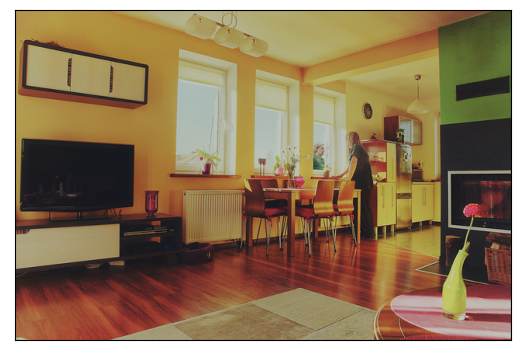

In [4]:
show(DS[0][0]), DS[0][1]

In [5]:
from pytorchyolo.detect import detect_image

In [6]:
import numpy as np
import PIL

In [34]:
model = yolo_v3()
model.eval()

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


In [37]:
model((DS[2][0],))[0]['labels'].to(torch.int)

tensor([64, 65, 62, 64, 84, 84, 84, 84, 44, 84, 84, 84, 84, 84, 84, 84, 84, 84],
       dtype=torch.int32)

In [17]:
model.train()

In [10]:
DS[i][1]

NameError: name 'i' is not defined

In [26]:
i = 2
loss = 0
model((DS[i][0], DS[i + 1][0]), (DS[i][1], DS[i + 1][1])).values()

tensor([0.0815, 0.0711, 0.0063, 0.1589]) [None, None, None, None]


dict_values([tensor(0.0815), tensor(0.0711), tensor(0.0063), None, None, None])

In [27]:
a = torch.rand(1, 4, requires_grad=True)

In [28]:
a

tensor([[0.4751, 0.5357, 0.9920, 0.9210]], requires_grad=True)

In [30]:
b = a ** 2
b

tensor([[0.2258, 0.2870, 0.9840, 0.8482]], grad_fn=<PowBackward0>)

In [32]:
c = b[0]
c

tensor([0.2258, 0.2870, 0.9840, 0.8482], grad_fn=<SelectBackward0>)

In [23]:
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

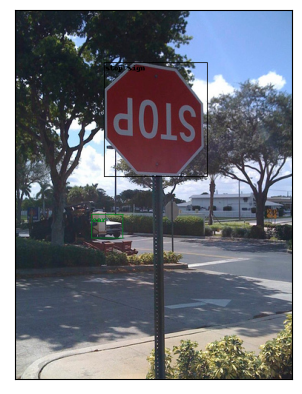

In [16]:
i = 3
model.eval()
preds = model((DS[i][0],))[0]
show(draw_bbox_with_tensor(DS[i][0], preds['boxes'], get_str_labels(preds['labels'])))

In [13]:
device = 'cuda'
# patch = torch.load('Exps/07-11-16-29/Data/patch.pt')
cats = COCO(config.annotation_path).cats


def get_str_labels(int_labels):
    str_labels = []
    if isinstance(int_labels, int):
        int_labels = [int_labels]
    for label in int_labels:
        str_labels.append(cats[int(label)]['name'])
    return str_labels

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [10]:
net2attack = fasterrcnn_mobilenet_v3_large_320_fpn_COCO().to(device)
net2attack.eval()
DS = coco_2017_dev_5k(config.folder_path, config.annotation_path, None, None)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [20]:
image_idx = 10
projector = PatternProjector(pattern_posi=(0, 0), pattern_scale=(0.9, 1.1), rotation_angle=(-10, 10), mix_rate=(0.9, 0.99), min_luminance=0.0, luminance_smooth_boundary=None)

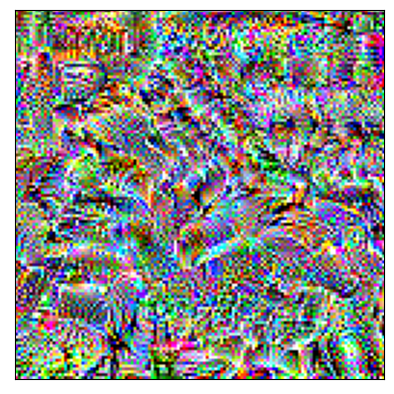

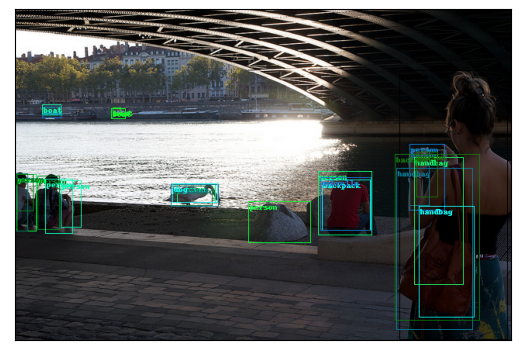

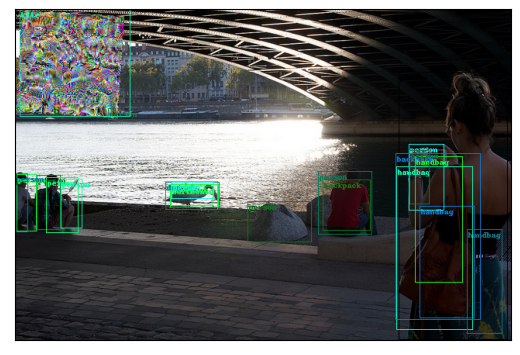

In [21]:
img = [DS[image_idx][0].to(device) for image_idx in (image_idx if isinstance(image_idx, (list, tuple)) else [image_idx])][0]
img_with_patch, pattern, (_, _) = projector(img.clone(), patch)

preds_clean_img = net2attack((img,))
boxes_clean_img = preds_clean_img[0]['boxes']
int_labels_clean_image = preds_clean_img[0]['labels']
str_labels_clean_image = get_str_labels(int_labels_clean_image)
example_image_clean = draw_bbox_with_tensor(img=img, bbox=boxes_clean_img, label=str_labels_clean_image)

preds_with_patch = net2attack((projector(img, patch.to(device))[0],))
boxes_with_patch = preds_with_patch[0]['boxes']
int_labels_with_patch = preds_with_patch[0]['labels']
str_labels_with_patch = get_str_labels(int_labels_with_patch)
example_with_patch = draw_bbox_with_tensor(img=img, bbox=boxes_with_patch, label=str_labels_with_patch)

show(patch)
show(example_image_clean)
show(example_with_patch)